# Main Runner

In [1]:
import pandas as pd

from objects import *
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
# Get all files in the experiments folder
experiment_names = os.listdir('experiments')
experiments = []
# read in pickle object
for e in experiment_names:
    with open(f"experiments/{e}", 'rb') as f:
        exp = pickle.load(f)
        experiments.append(exp)
exp = experiments[0]

In [3]:
# csmpo = RigidDayTrading(exp, verbose = False)
nmpo = NaivePolicy(exp, verbose=True)

In [4]:
# market_sim = MarketSimulator(exp,csmpo)
market_sim = MarketSimulator(exp, nmpo)

In [5]:
final_portf = market_sim.run()

Starting Simulation


  0%|          | 0/30 [00:00<?, ?it/s]

Current Portfolio Value at 2021-05-11: 205517.0
	 Optimized. Time taken: 0.007632255554199219


100%|██████████| 30/30 [00:03<00:00,  8.24it/s]


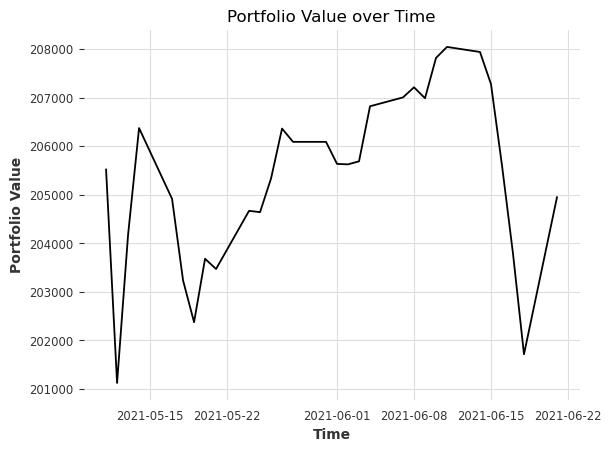

In [6]:
market_sim.plot_value()

Starting Simulation


100%|██████████| 30/30 [04:24<00:00,  8.81s/it]


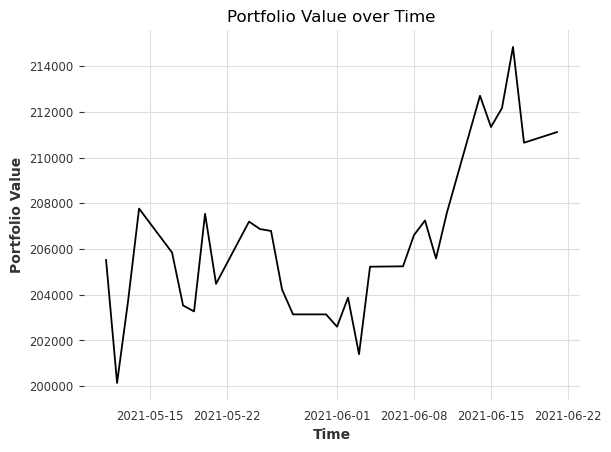

In [7]:
csmpo = DayTradingPolicy(exp, verbose = False)
day_trading_runner = MarketSimulator(exp,csmpo)
day_trading_runner.run()
day_trading_runner.plot_value()

In [ ]:
multi_sim = MultiSimRunner(experiments[:6], ["RigidDayTrading", "DayTrading"])
multi_sim.run()

In [ ]:
multi_sim.get_results()